In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
#Make sure versions of libraries are up to date

import tensorflow as tf
print(tf.__version__)
print(pd.__version__)

1.12.0
0.23.4


In [3]:
#Define main folder and images folder as well as define an example picture

main_folder = 'input_data_celeb/celeba_dataset/'
images_folder = main_folder +'img_align_celeba/'

EXAMPLE_PIC = images_folder + '1.png'
#EXAMPLE_PIC = 'C://Users/karim/1.png'


#Set important variables that will be used throughout the program

TRAINING_SAMPLES = 660
VALIDATION_SAMPLES = 170
TEST_SAMPLES = 170
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
NUM_EPOCHS = 15

In [9]:
#Import the dataset (csv file) that contains the list of attributes

df_attr = pd.read_csv('attribute_list_mediumset.csv')
df_attr.set_index('file_name', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(1000, 5)

In [10]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 hair_color
1 eyeglasses
2 smiling
3 young
4 human


smiling    1
young      1
human      0
Name: 1.png, dtype: int64

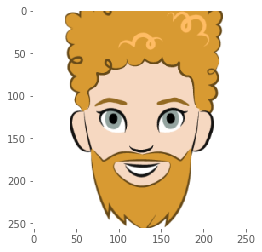

In [11]:
#Plot the example picture with some of its attributes - Test Example
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['smiling','young','human']] #some attributes

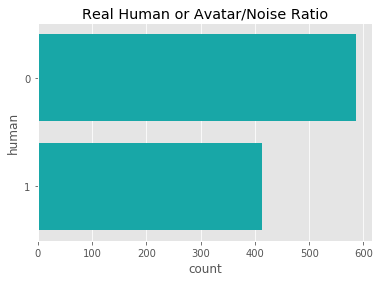

In [12]:
# Determine the Character and Avatar Ratio for better Test/Val/Test split
plt.title('Real Human or Avatar/Noise Ratio')
sns.countplot(y='human', data=df_attr, color="c")
plt.show()

In [13]:
#Partition file created to allocate pictures for each operation
df_partition = pd.read_csv('list_eval_partition_mediumset.csv')
df_partition.head()

,file_name,partition
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0


In [14]:
# Display the counter by partition
# 0 -> Training
# 1 -> Validation
# 2 -> Test
df_partition['partition'].value_counts().sort_index()

0    660
1    170
2    170
Name: partition, dtype: int64

In [15]:
# Join the partition dataframe with the attributes dataframe
df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['human'], how='inner')
df_par_attr.tail(100)
#df_par_attr['human'].value_counts().sort_index()

,partition,human
file_name,,
901.png,2,1
902.png,2,0
903.png,2,0
904.png,2,0
905.png,2,0
906.png,2,1
907.png,2,1
908.png,2,0
909.png,2,0


In [12]:
#Define function that allows to retrieve images and reshaping them

def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

#Define function that constructs dataframe for the training operations

def generate_df_TRAIN(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/4))])

    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)

    return x_, y_

In [13]:
#Define function that constructs dataframe for the validation operations

def generate_df_VAL(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(4))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(6))])

    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],2)
    

    return x_, y_

In [14]:
#Define function that constructs dataframe for the testing operations

def generate_df_TEST(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    x_ = []
    y_ = []

    for index, target in df_.iterrows():
        im = cv2.imread(images_folder + index)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

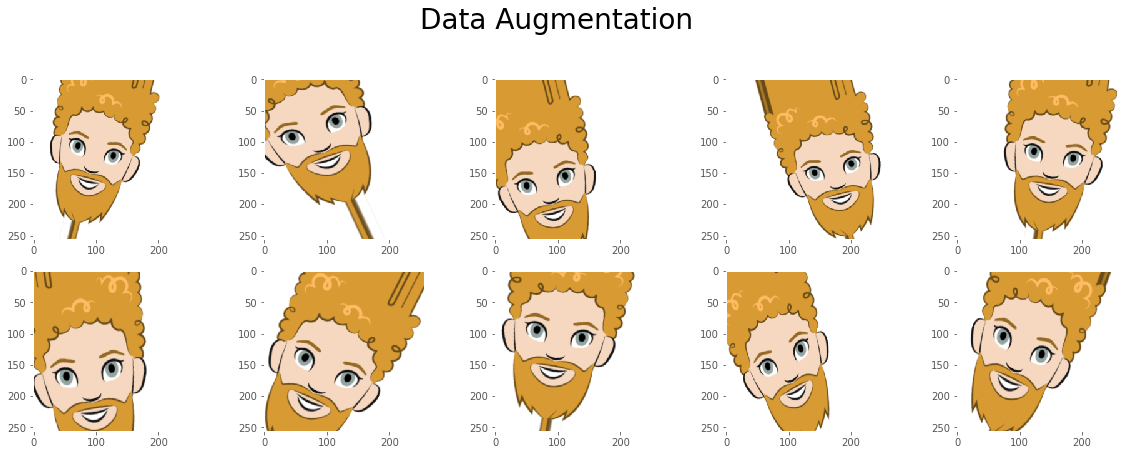

In [16]:
# Data Augmentation step using image generator
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(256, 256, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [16]:
# Train data
x_train, y_train = generate_df_TRAIN(0, 'human', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [17]:
# Validation Data
x_valid, y_valid = generate_df_TRAIN(1, 'human', VALIDATION_SAMPLES)


'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [18]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [19]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [20]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [21]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.human2.hdf5', 
                               verbose=1, save_best_only=True)

In [22]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/15
44/43 [==============================] - 461s 10s/step - loss: 0.6528 - acc: 0.6581 - val_loss: 0.5452 - val_acc: 0.7800

Epoch 00001: val_loss improved from inf to 0.54525, saving model to weights.best.inc.human2.hdf5
Epoch 2/15
44/43 [==============================] - 442s 10s/step - loss: 0.4851 - acc: 0.7760 - val_loss: 0.4404 - val_acc: 0.8933

Epoch 00002: val_loss improved from 0.54525 to 0.44045, saving model to weights.best.inc.human2.hdf5
Epoch 3/15
44/43 [==============================] - 442s 10s/step - loss: 0.3746 - acc: 0.8765 - val_loss: 0.3637 - val_acc: 0.9667

Epoch 00003: val_loss improved from 0.44045 to 0.36366, saving model to weights.best.inc.human2.hdf5
Epoch 4/15
44/43 [==============================] - 454s 10s/step - loss: 0.2961 - acc: 0.9332 - val_loss: 0.2957 - val_acc: 0.9733

Epoch 00004: val_loss improved from 0.36366 to 0.29569, saving model to weights.best.inc.human2.hdf5
Epoch 5/15
44/43 [==============================] - 445s 10s/step - 

KeyboardInterrupt: 

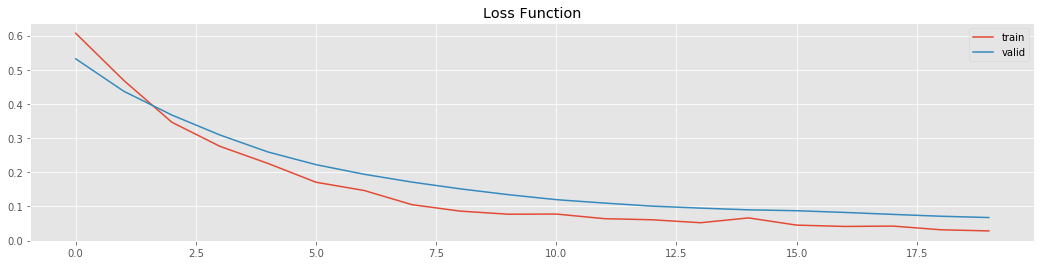

In [98]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

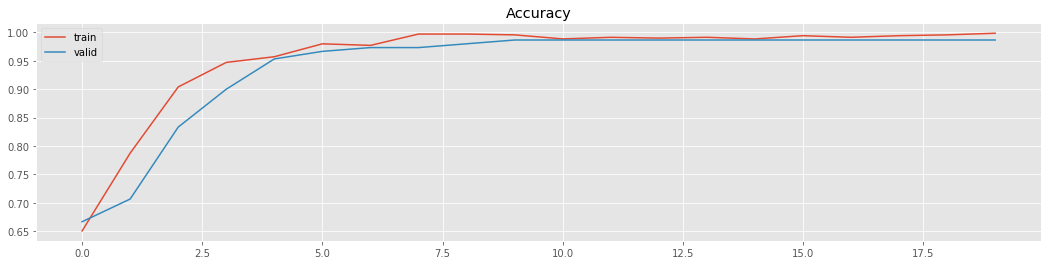

In [99]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [100]:
#load the best model
model_.load_weights('weights.best.inc.human2.hdf5')

In [106]:
# Test Data
x_test, y_test = generate_df_TEST(2, 'human', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 99.0000%
f1_score: 0.98989898989899


In [124]:
#dictionary to name the prediction
attribute_target = {0: 'Avatar/Noise'
                , 1: 'Real Human'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display results in HTML for better visualisation
    
    '''

    attribute = 'Real Human'
    arrow_icon = "https://i.imgur.com/nxWan2u.png"
    
    #print(prediction)
    
    if prediction[1] <= 0.5:
        arrow_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Avatar/Noise'
            
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 5px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 10px; font-size: 10px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 25px; font-size: 10px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , arrow_icon
               , attribute
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , attribute_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [109]:
def attribute_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    


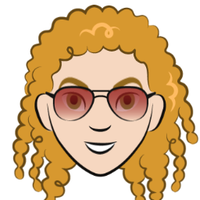


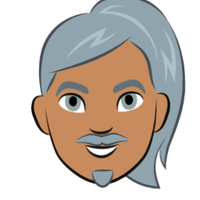


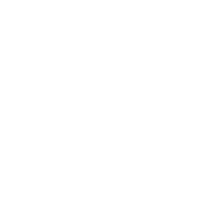


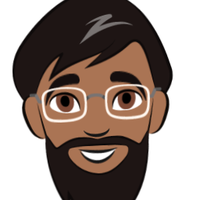


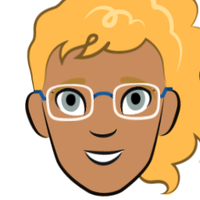


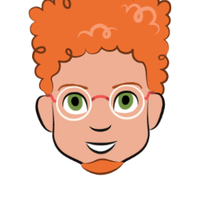


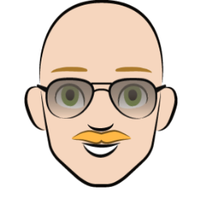


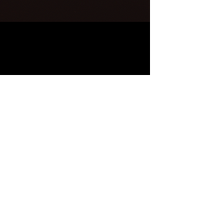


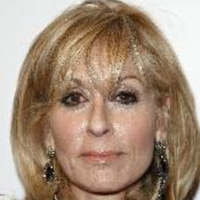


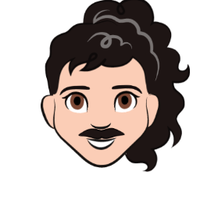


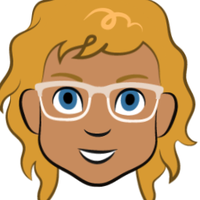


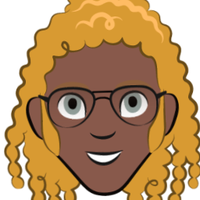


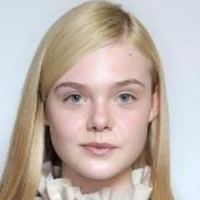


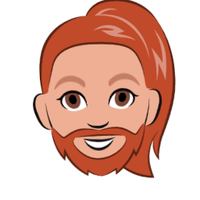


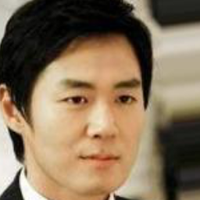


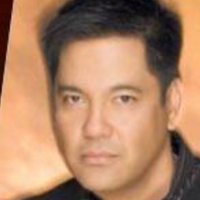


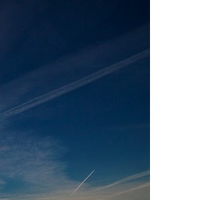


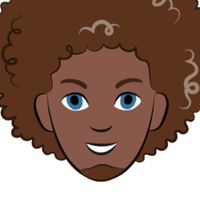


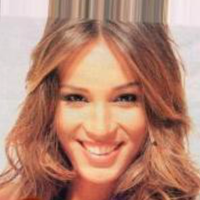


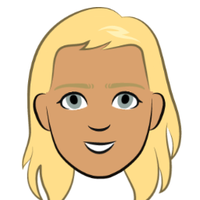


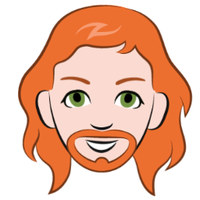


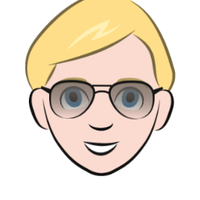


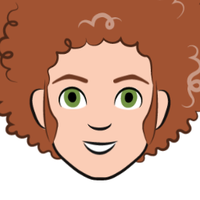


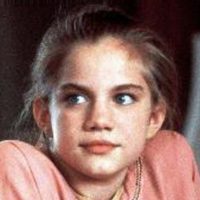


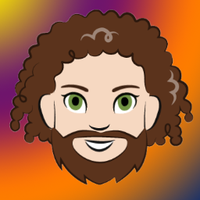


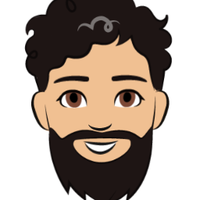


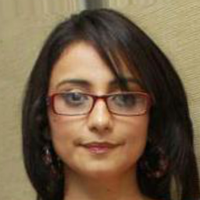


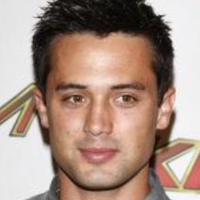


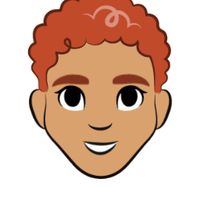


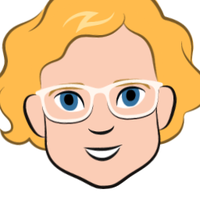


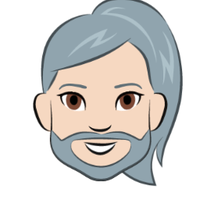


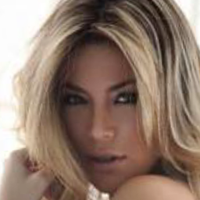


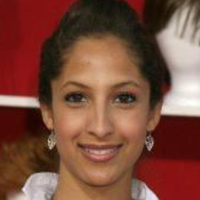


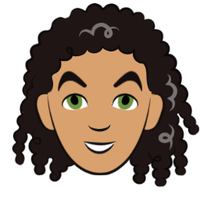


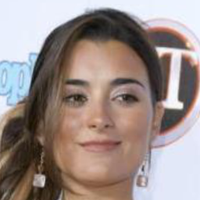


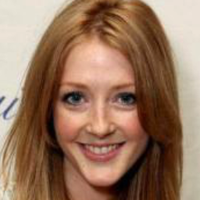


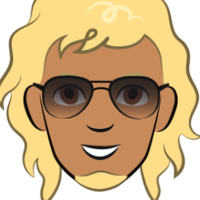


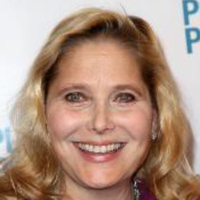


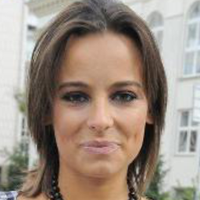


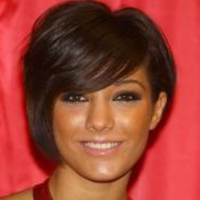

In [125]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(40)

for index, target in df_to_test.iterrows():
    result = attribute_prediction(images_folder + index)
    
    #display result
    display_result(images_folder + index, result[0], target['human'])